In [5]:
# Initialization
import numpy as np
import scipy as sp
from ase import Atoms
from ase.io.trajectory import Trajectory
from matplotlib import pyplot as plt

plt.rcParams['text.usetex'] = True # Allows for TeX in figures

# Importing the trajectories
traj_AIMD = Trajectory('Data/Dynamics.traj')       # Our AIMD
traj_Na   = Trajectory('Na-aimd/NaCluster24.traj') # Git trajectory w Na+
traj_H2O  = Trajectory('Na-aimd/cluster24.traj')   # Git trajectory w/o Na+

In [30]:
# Finding the RDF and the first solvation shell
def RDF(traj,a_id=72,start=0,stop=None):
    '''
    Arguments:
        traj  - Trajectory object
        a_id  - ID of atom to be analyzed
        start - Initial step of trajectory
        stop  - Final step of trajectory

    Returns:
        r      - Radius-array
        gPrime - Array of RDF(r)-values
        SH     - Coordination number
    '''
    if stop == None:
        stop = len(traj) # Default stop snapshot is the final one
    
    d = np.zeros([])         # Empty distance array to be filled
    V = traj[0].get_volume() # Cell volume
    rho = V/len(traj[0])     # Particle density

    w = traj[0].get_cell_lengths_and_angles()[0] # Cell width

    # Distance from Na+ to O for each timestep
    for i in range(start,stop):
        atoms = traj[i]
        d_i = atoms.get_distances(a_id,
                atoms.get_atomic_numbers()==8,mic=True) # Distances to oxygen
                
        d_i = np.where(d_i<w,d_i,d_i-w) # Applying the boundary condition
        d_i = d_i[d_i != 0] # Disregard distances to the atom itself

        d = np.append(d,d_i) # Add to list
    
    #d = d[d != 0] # Disregard distances to the atom itself 

    # Finding the RDF g(r)
    #plt.hist(d,bins=100)
    hist = np.histogram(d,bins=100) # Data binning
    dr   = hist[1][1] - hist[1][0]
    r    = hist[1][1:] - dr/2
    dn_r = hist[0]/(stop-start)

    print(hist[0])

    gPrime = dn_r*(4*np.pi*r**2*dr*rho)**-1
    #g = dn_r*(dr)**-1
    
    # Finding the first solvation shell
    r_1,r_2 = 3,5 # Approximated radii
    minapprox = int((r_1-r[0])/dr) # Approximation of first minimum
    min = np.argmin(gPrime[minapprox-r_2:minapprox+r_2]) + minapprox - r_2

    SH = sum(hist[0][:min])/(stop-start) # Solvation shell

    print(hist[0][:min])
     
    return [r,gPrime], SH

# Evaluating the RDFs and the coordination numbers
#data,SH = RDF(traj_AIMD)
#data_Na,SH_Na = RDF(traj_Na,start=3500)
data_H2O,SH_H2O = RDF(traj_H2O,a_id=4,start=2000)

[   1    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   16   20  234 1783 5544 7816 7050 5605 3538 2725 1673 1376 1163
 1382 1320 1776 1960 2315 2688 3694 4015 4186 4124 4509 6452 7797 8669
 8816 8475 9319 8680 7057 7394 7781 6436 6665 5253 5275 4441 3924 3911
 4192 3803 3799 3661 3382 2981 2604 2065 2079 1762 1204  984  700  564
  544  874 1003  884 1141  992  899  628  557  444  436  222  244  145
  201  149]
[   1    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   16   20  234 1783 5544 7816 7050 5605 3538 2725 1673 1376]


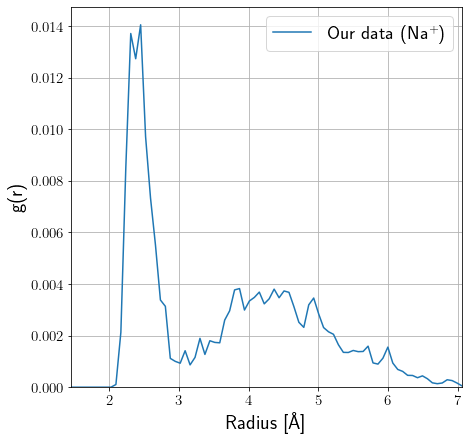

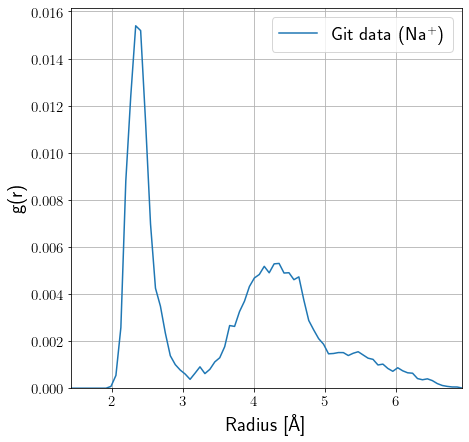

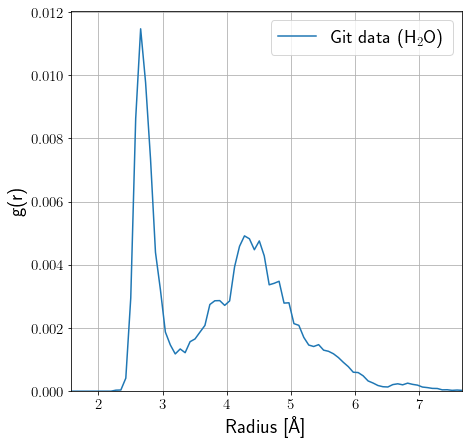

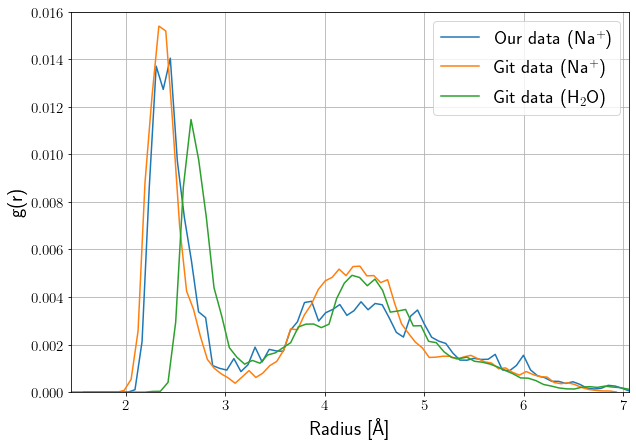

In [21]:
# Plotting
save_figs = False

# Individual figures
fig1,ax1 = plt.subplots(figsize=(7,7)) # Our AIMD
fig2,ax2 = plt.subplots(figsize=(7,7)) # Git AIMD w Na
fig3,ax3 = plt.subplots(figsize=(7,7)) # Git AIMD w/o Na

ax    = [ax1,ax2,ax3]
radii = [data[0],data_Na[0],data_H2O[0]]
rdf   = [data[1],data_Na[1],data_H2O[1]]
label = [r'Our data (Na$^+$)',r'Git data (Na$^+$)',r'Git data (H$_2$O)']

for i in range(3):
    ax[i].plot(radii[i][20:],rdf[i][20:],label=label[i])
    ax[i].tick_params(axis = 'both', labelsize = 15)
    ax[i].set_xlabel(r"Radius [Å]",fontsize=20)
    ax[i].set_ylabel(r"g(r)",fontsize=20)
    ax[i].set_xlim([radii[i][20],radii[i][-1]])
    ax[i].set_ylim([0,1.05*np.amax(rdf[i][20:])])
    ax[i].grid()
    ax[i].legend(fontsize=19)

# Superimposed plot
fig_all,ax_all = plt.subplots(figsize=(10,7))

ax_all.plot(radii[0][20:],rdf[0][20:],label=r'Our data (Na$^+$)')
ax_all.plot(radii[1][20:],rdf[1][20:],label=r'Git data (Na$^+$)')
ax_all.plot(radii[2][20:],rdf[2][20:],label=r'Git data (H$_2$O)')

ax_all.tick_params(axis = 'both', labelsize = 15)
ax_all.set_xlabel(r"Radius [Å]",fontsize=20)
ax_all.set_ylabel(r"g(r)",fontsize=20)
ax_all.set_xlim([radii[0][20],radii[0][-1]])
ax_all.set_ylim([0,0.016])
ax_all.grid()
ax_all.legend(fontsize=19)

# Saving the figures
if save_figs == True:
    fig1.savefig('Figures/RDF our NA.pdf',bbox_inches='tight')
    fig2.savefig('Figures/RDF their Na.pdf',bbox_inches='tight')
    fig3.savefig('Figures/RDF Only H2O.pdf',bbox_inches='tight')
    fig_all.savefig('Figures/RDF superimposed.pdf',bbox_inches='tight')

In [32]:
print(np.zeros([]))
print(f'Our Na:    SH = {SH}')
print(f'Their Na:  SH = {SH_Na}')
print(f'Their H20: SH = {SH_H2O}')

0.0
Our Na:    SH = 4.655
Their Na:  SH = 4.4187619047619044
Their H20: SH = 3.7381
